In [1]:
import glob
import os
import pprint
import traceback
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
 def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        'compressedHistograms': 1,
        'images': 1,
        'scalars': 0,  # 0 means load all
        'histograms': 1,
    }
    runlog_data = pd.DataFrame({'metric': [], 'value': [], 'step': []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()['scalars']
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {'metric': [tag] * len(step), 'value': values, 'step': step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print('Event file possibly corrupt: {}'.format(path))
        traceback.print_exc()
    return runlog_data

In [3]:
experiments = []
for cost in ['reward', 'critic_train', 'critic_eval']:
    experiments.append(f'sac_state_cost-{cost}')

In [5]:
path = '../../../output/final/fetch-push-barrier-final-2/'
exp_dict = {}
for exp in experiments:
    for i in range(3):
        tb = glob.glob(os.path.join(path, f'{exp}_{i}/tb/*'))
        if exp in exp_dict:
            exp_dict[exp].append(tb[0])
        else:
            exp_dict[exp] = tb

In [6]:
exp_dict = {k: list(map(lambda x: tflog2pandas(x), iter(v))) for k, v in exp_dict.items()}

In [9]:
exp_dict2 = {}
for k, v in exp_dict.items():
    df = pd.DataFrame()
    for frame in v:
        df = df.append(frame, ignore_index=True)
    split = k.split('_')
    assert split[2] in ['cost-reward', 'cost-critic'], split[1]
    if split[2] == 'cost-critic':
        assert split[3] in ['train', 'eval'], split[2]
        name = split[3]
    else:
        name = 'reward'
    df['algo'] = name
    exp_dict2[k] = df

In [10]:
logs = pd.DataFrame()
for frame in exp_dict2.values():
    logs = logs.append(frame, ignore_index=True)

In [11]:
logs = logs.sort_values(by=['algo'])

In [12]:
logs[logs['metric']=='train/success_rate']

,metric,value,step,algo
10355966,train/success_rate,0.08,518250.0,eval
10355967,train/success_rate,0.08,518400.0,eval
10355968,train/success_rate,0.08,518550.0,eval
10355969,train/success_rate,0.08,518700.0,eval
10355970,train/success_rate,0.08,518850.0,eval
...,...,...,...,...
7187293,train/success_rate,0.00,600.0,train
7187292,train/success_rate,0.00,450.0,train
7187291,train/success_rate,0.00,300.0,train
7187290,train/success_rate,0.00,150.0,train


In [2]:
def plot(data, metric, name, y_low, y_high, image_name=None, color_palette="colorblind", dashes=None, legend=True, legend_offset=-0.11, size=(20,10)):
    fig = plt.figure(figsize=size)
    fig.patch.set_facecolor('white')
    plt.ticklabel_format(scilimits=[-5,3])
    

    # set style and context
    sns.set_context("notebook")
    sns.set(style='whitegrid', font_scale=2)

    # create graph
    graph = sns.lineplot(data=data[data['metric']==metric], 
                        x='step', 
                        y='value', 
                        hue='algo',
                        style='algo',
                        ci='sd',
                        palette=color_palette,
                        dashes=dashes)

    # set legend options
    handles, labels = graph.get_legend_handles_labels()
    if legend:
        fig.legend(loc='lower center', 
                   bbox_to_anchor=(0.5, legend_offset), 
                   fancybox=True, 
                   shadow=True, 
                   ncol=5, 
                   prop={'size': 19})

    # graph options
    graph.legend([],[], frameon=False)
    graph.set(xlabel='Environment Steps', ylabel=name)
    #graph.title.set_text('FetchReach')
    #graph.title.set_size(26)
    graph.set_ylim(y_low, y_high)
    graph.set_xlim(0, 4000000)
    #fig.tight_layout(pad=2.0)
    if image_name != None:
        plt.savefig(image_name, bbox_inches='tight')#, pad_inches=0.1)

In [14]:
logs.to_pickle('results/push-barrier/graph_data.pkl')

In [3]:
logs = pd.read_pickle('results/push-barrier/graph_data.pkl')

In [4]:
logs.replace('eval', 'Safety Evaluation', inplace=True)
logs.replace('train', 'Safety Training', inplace=True)
logs.replace('reward', 'Reward Based', inplace=True)

In [5]:
dashes = {algo: () if i <= 9 else (6,4) for i, algo in enumerate(logs['algo'].unique())}

In [6]:
colors = {algo: sns.color_palette('colorblind', logs['algo'].nunique())[i] for i, algo in enumerate(logs['algo'].unique())}

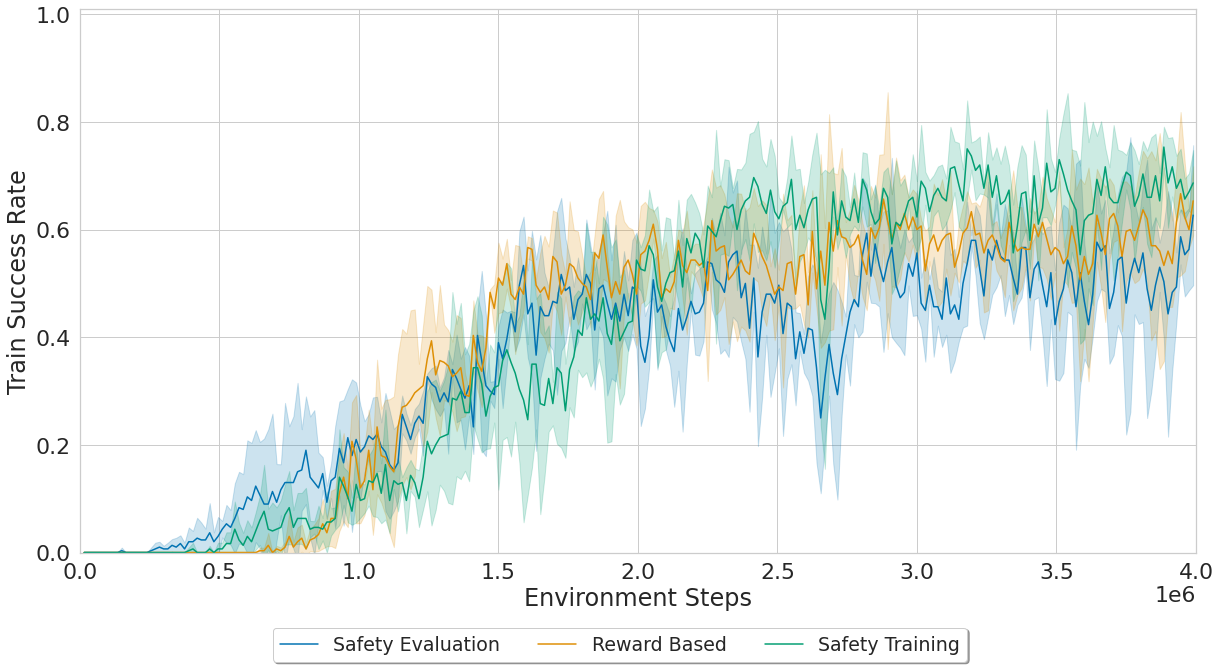

In [9]:
plot(logs[logs['step']%5000==0], 'train/success_rate', 'Train Success Rate', 0, 1.01, 'results/push-barrier/success.png', colors, dashes, legend_offset=-0.04)

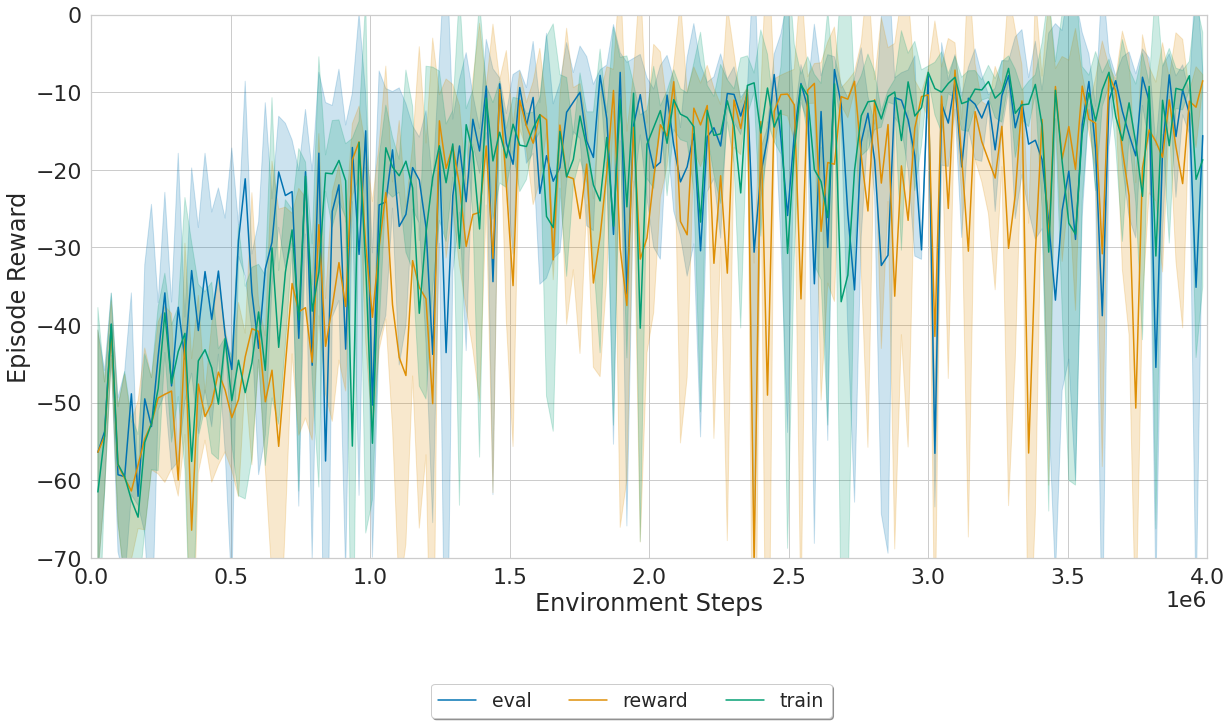

In [26]:
plot(logs[logs['step'] % 8000 == 0], 'train/episode_reward', 'Episode Reward', -70, 0, 'results/push-barrier/reward.png', colors, dashes)

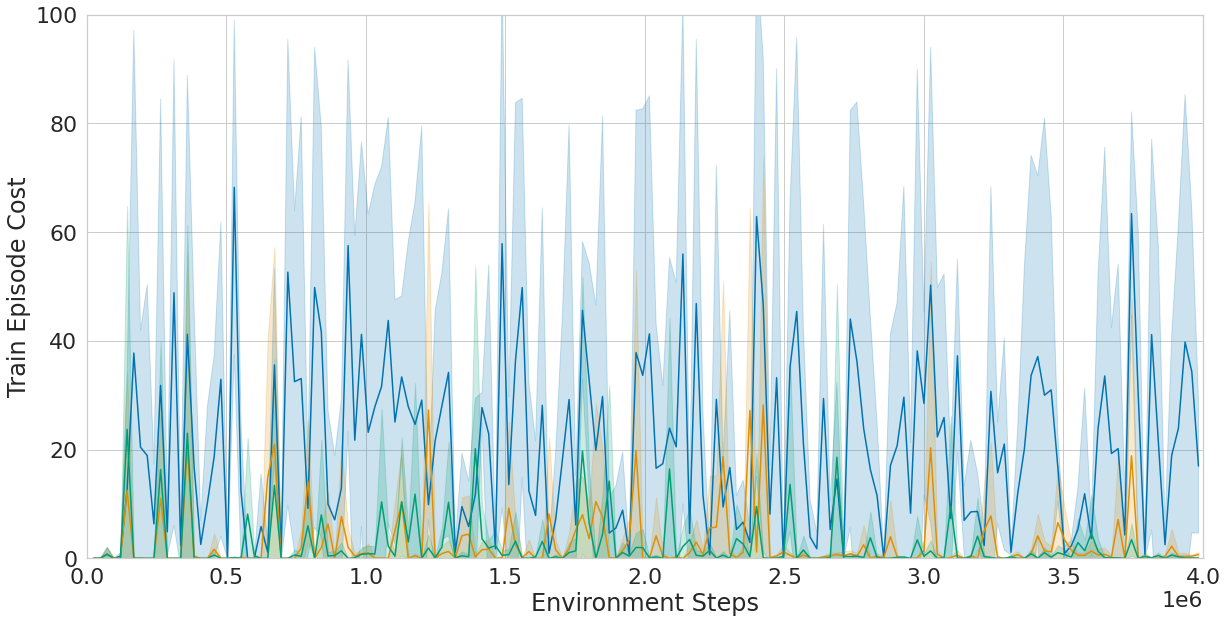

In [12]:
plot(logs[logs['step'] % 8000 == 0], 'train/episode_cost', 'Train Episode Cost', 0, 100, 'results/push-barrier/cost.png', colors, dashes, legend_offset=-0.04, legend=False)

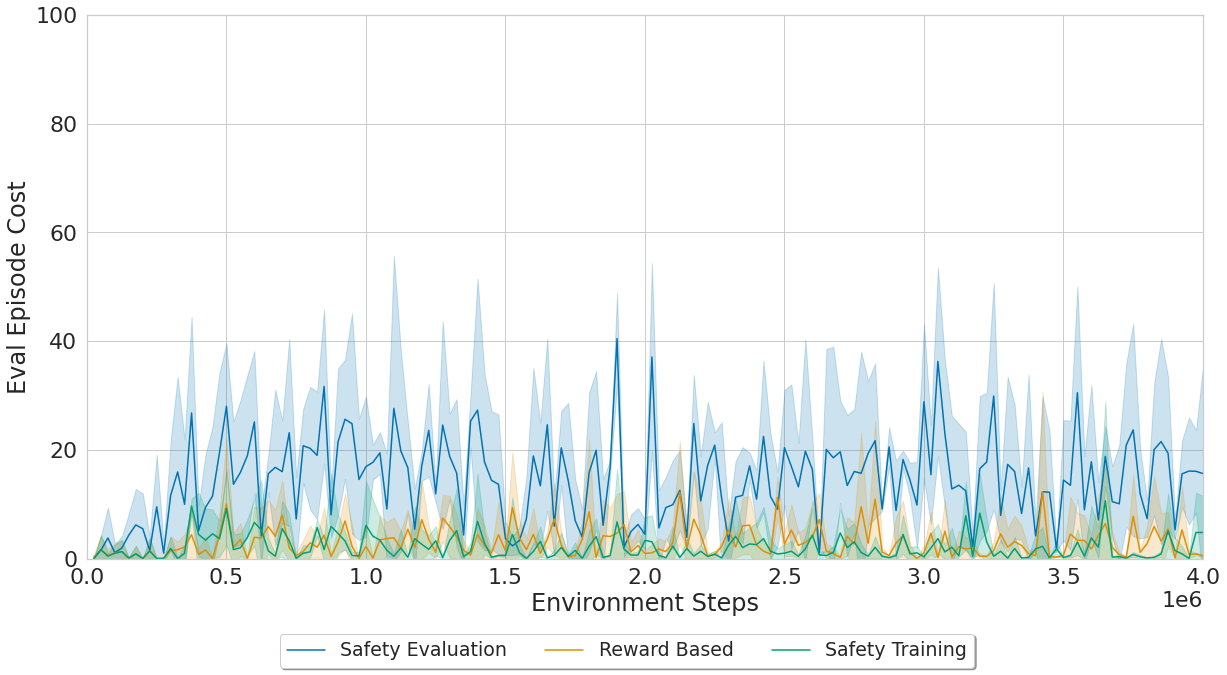

In [11]:
plot(logs, 'eval/episode_cost', 'Eval Episode Cost', 0, 100, 'results/push-barrier/eval_cost.png', colors, dashes, legend_offset=-0.04, legend=True)

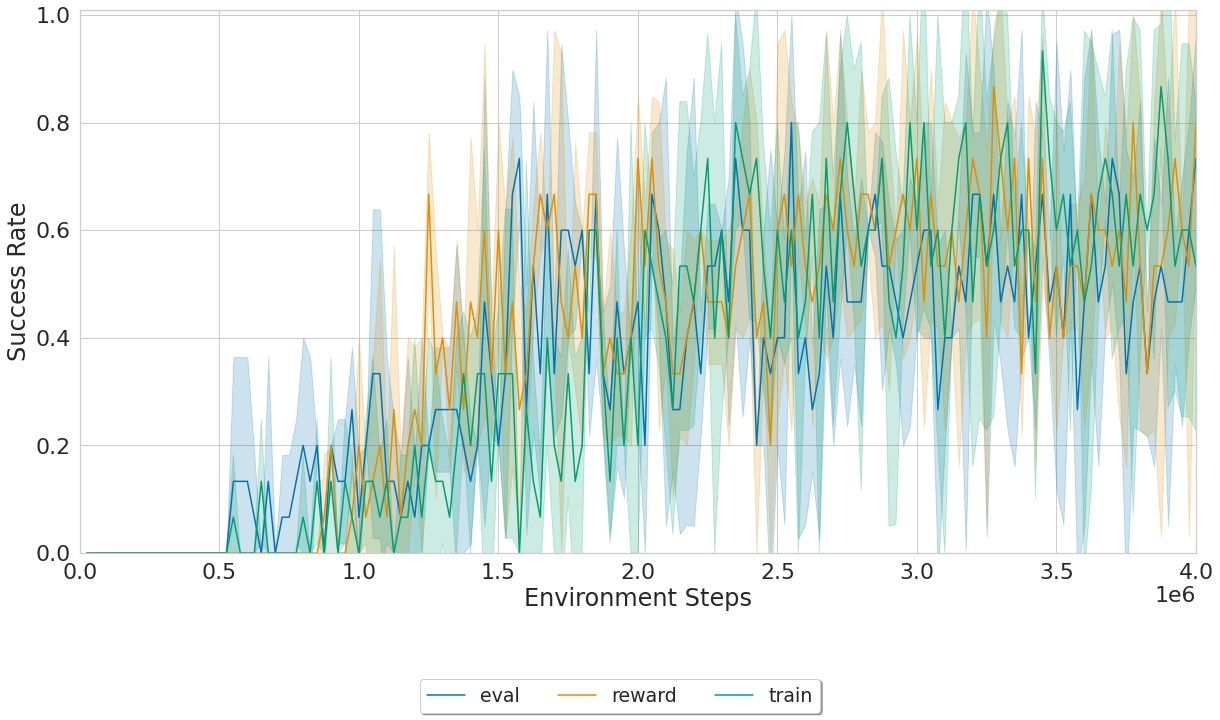

In [20]:
plot(logs, 'eval/success_rate', 'Success Rate', 0, 1.01, 'results/push-barrier/eval_success.png', colors, dashes)

In [37]:
x = sns.color_palette('colorblind')

In [41]:
x[0]

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)

In [39]:
x

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [19]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [20]:
rgb_to_hex(tuple([int(255*x) for x in colors['Safety Evalu']]))

'029e73'

In [51]:
rgb_to_hex(tuple([int(255*x) for x in x[0]]))

'0173b2'

In [52]:
rgb_to_hex(tuple([int(255*x) for x in x[1]]))

'de8f05'

In [53]:
rgb_to_hex(tuple([int(255*x) for x in x[2]]))

'029e73'

In [56]:
rgb_to_hex(tuple([int(255*x) for x in x[4]]))

'cc78bc'

In [48]:
tuple([int(255*x) for x in x[0]])

(1, 115, 178)